## Import necessary libraries

In [1]:
!pip install -q --no-cache-dir mne lightning torchmetrics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 299.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 343.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 320.4 MB/s eta 0:00:00


In [4]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.2 MB/s eta 0:00:00


In [5]:
import mne
from mne.io import concatenate_raws

import os
import re
import io
import cv2
import random
import string
import pickle
import warnings
import math
import numpy as np
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

import torch
from torch import nn, Tensor
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.autograd import Variable
from einops.layers.torch import Rearrange

import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

from torchmetrics.classification import Accuracy

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'


In [6]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


## Load Physionet dataset

In [7]:
# EEG Motor Movement/Imagery Dataset:
# https://physionet.org/content/eegmmidb/1.0.0/

# This dataset consists of over 1500 one- and two-minute EEG recordings,
# sampled at 160 Hz, obtained from 109 volunteers.

# In summary, the experimental runs were:
# Run 1: Baseline, eyes open
# Run 2: Baseline, eyes closed
# Run 3: Task 1 (open and close left or right fist)
# Run 4: Task 2 (imagine opening and closing left or right fist)
# Run 5: Task 3 (open and close both fists or both feet)
# Run 6: Task 4 (imagine opening and closing both fists or both feet)
# Run 7: Task 1
# Run 8: Task 2
# Run 9: Task 3
# Run 10: Task 4
# Run 11: Task 1
# Run 12: Task 2
# Run 13: Task 3
# Run 14: Task 4

# Each annotation includes one of three codes of events (T0=1, T1=2, or T2=3):
# - T0 corresponds to rest
# - T1 corresponds to onset of motion (real or imagined) of
#     > the left fist (in runs 3, 4, 7, 8, 11, and 12)
#     > both fists (in runs 5, 6, 9, 10, 13, and 14)
# - T2 corresponds to onset of motion (real or imagined) of
#     > the right fist (in runs 3, 4, 7, 8, 11, and 12)
#     > both feet (in runs 5, 6, 9, 10, 13, and 14)


warnings.filterwarnings("ignore")

N_SUBJECTS = 109
BASELINE_EYE_OPEN = [1]
BASELINE_EYE_CLOSED = [2]
OPEN_CLOSE_LEFT_RIGHT_FIST = [3, 7, 11]
IMAGINE_OPEN_CLOSE_LEFT_RIGHT_FIST = [4, 8, 12]
OPEN_CLOSE_BOTH_FIST = [5, 9, 13]
IMAGINE_OPEN_CLOSE_BOTH_FIST = [6, 10, 14]
data_path = "drive/MyDrive/Colab Notebooks/physionet_dataset.pkl"

## Use all subjects
# To speed up the process only load the data if it cannot be found locally
if os.path.isfile(data_path):
    with open(data_path, 'rb') as f:
        raw_obj_set = pickle.load(f)
else:
    physionet_files = [
    mne.datasets.eegbci.load_data(
        id,
        IMAGINE_OPEN_CLOSE_LEFT_RIGHT_FIST,
        "/root/mne_data",
    )
    for id in range(1, N_SUBJECTS+1)
    ]
    physionet_files = np.concatenate(physionet_files)

    # Read the downloaded raw data files where each file contains a run and place them in a list
    raws = [
    mne.io.read_raw_edf(
        physionet_file,
        preload=True,
        stim_channel='auto',
        verbose='WARNING',
    )
    for physionet_file in physionet_files
    ]

    # Split the raw data files per subject
    raws_set = list(zip(*[iter(raws)] * 3))

    # Combine all loaded runs into one edf object
    raw_obj_set = [concatenate_raws(list(raw)) for raw in raws_set]

    with open(data_path, 'wb') as f:
        pickle.dump(raw_obj_set, f)


In [8]:
# For 109 subjects:
print(len(raw_obj_set))
print(len(raw_obj_set[0])) # Total number of EEG samples in the dataset of 1 subject, sanity check: approximated as 2 x 60 x 160 x 1 x 3 = 57600
print(type(raw_obj_set))


109
60000
<class 'list'>


In [9]:
print(raw_obj_set[0].info) # The data has not been filtered yet and is thus still very raw

<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: 3 items (dict)
>


In [10]:
channel_names = raw_obj_set[0].info['ch_names']
print(channel_names)


['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']


Let's visually inspect our data by plotting an example segment

Matrix dimensions of data in raw_obj:  (64, 60000)
Total number of channels:  64


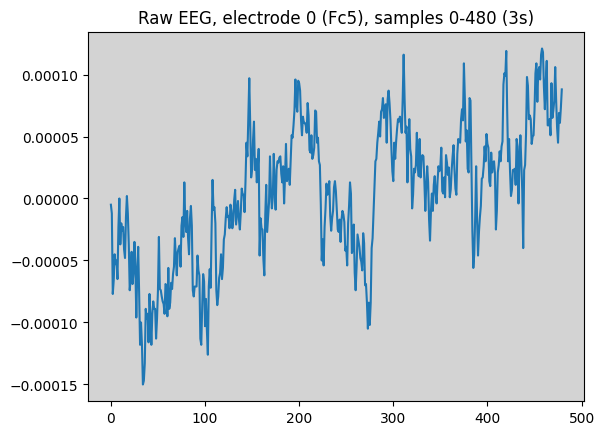

In [11]:
# Let's plot an example data segment of our raw_obj object
raw_data_example = raw_obj_set[0].get_data()

# After extracting the data from the edf object, it is placed in a matrix with dimensions [channels x time]
print("Matrix dimensions of data in raw_obj: ", str(np.shape(raw_data_example)))
print("Total number of channels: ", str(len(raw_data_example)))
plt.plot(raw_data_example[0,:480])
plt.title("Raw EEG, electrode 0 (Fc5), samples 0-480 (3s)")
plt.show()


## General preprocessing

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)


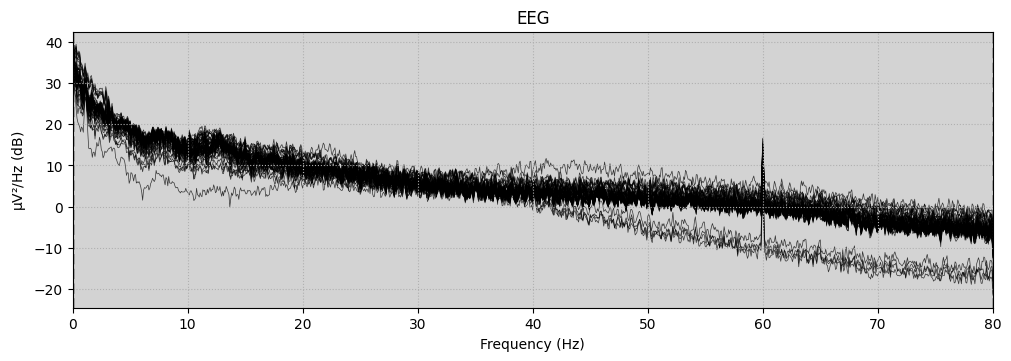

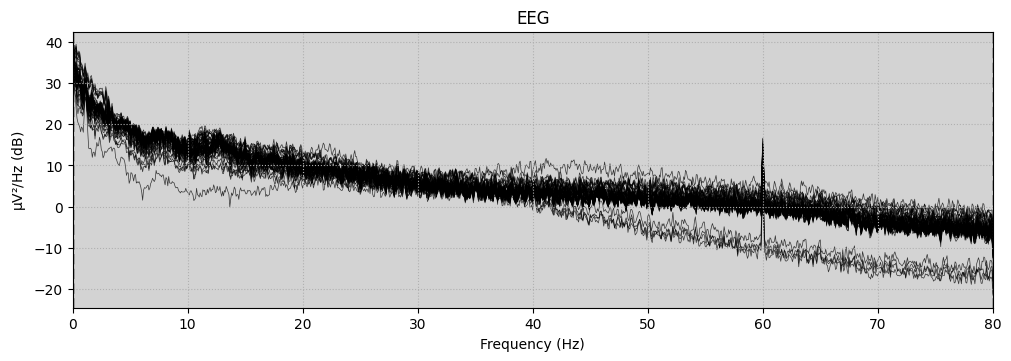

In [12]:
# First, let's inspect the general PSD characteristics of the data's PSD
raw_obj_set[0].plot_psd()


We see heavy powerline interference, which can be removed here through a notch filter at the frequency f = 60 Hz. However, [papers](https://iopscience.iop.org/article/10.1088/1741-2552/ac74e0) suggest that, for motor imagery, only information between 8-30 Hz is relevant. Because of this, we can just apply a bandpass filter to eliminate low frequency interference, high frequency noise and powerline intereference all in one go! To have some margin, in case the emotions team is interested in a broader frequency range than us, we choose a pass band of 0.5 Hz - 45 Hz for the general preprocessing filters. Later, during feature extraction, we can be more specific about the frequency band power features that we're interested in specifically for motor imagery anyway.

Note: In case the emotions team would want an even broader frequency range, then we could just use a notch filter at 60 Hz here together with a high pass filter at 0.5 or 1 Hz to remove the low frequency interference and powerline interference whilst leaving the highest frequency component present in the data still an open question.

In [13]:
l_freq = 0.5
h_freq = 45

raw_obj_set = [raw_obj.load_data().filter(l_freq, h_freq) for raw_obj in raw_obj_set]


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)


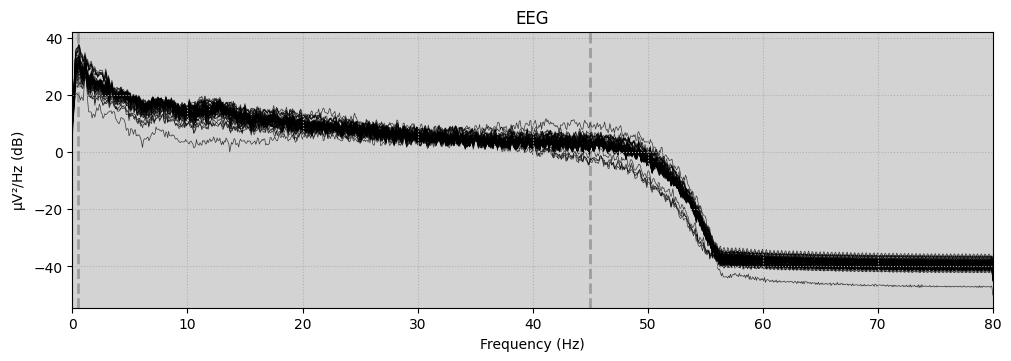

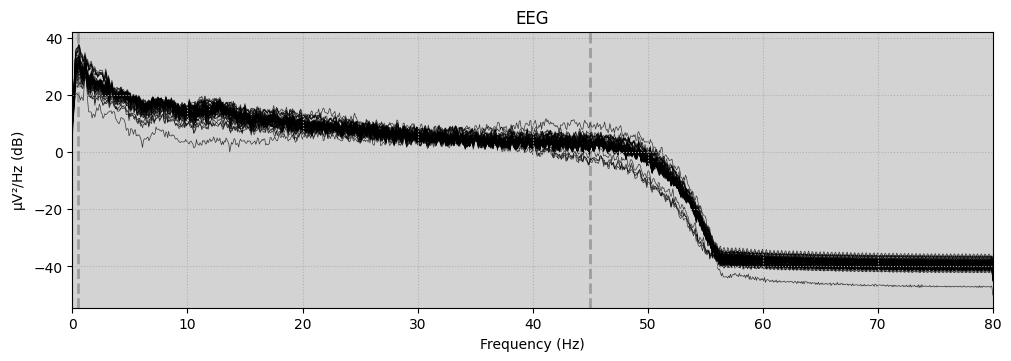

In [14]:
# Check result
raw_obj_set[0].plot_psd()


The same papers also mention that common average referencing is recommended for MI applications

In [15]:
raw_obj_set = [raw_obj.set_eeg_reference('average') for raw_obj in raw_obj_set]


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
E

Again, plot an eeg segment to visually inspect the new signal

Matrix dimensions of data in raw_obj:  (64, 60000)
Total number of channels:  64


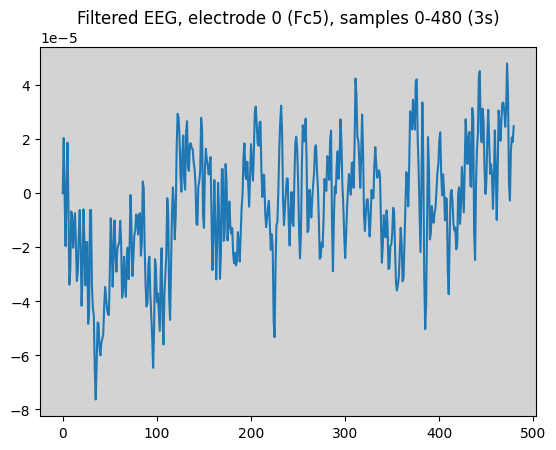

In [16]:
# Let's plot an example data segment of our raw_obj object
raw_data_example = raw_obj_set[0].get_data()

# After extracting the data from the edf object, it is placed in a matrix with dimensions [channels x time]
print("Matrix dimensions of data in raw_obj: ", str(np.shape(raw_data_example)))
print("Total number of channels: ", str(len(raw_data_example)))
plt.plot(raw_data_example[0,:480])
plt.title("Filtered EEG, electrode 0 (Fc5), samples 0-480 (3s)")
plt.show()


In [ ]:
# Note: it might be necessary to make the high cut-off frequency a bit lower, as
# we'll be dealing with 50 Hz powerline noise instead of 60 Hz...


## Events / annotations

Typically, during an experiment we mark the time when important events occur by integrating triggers into an EEG recording, which can be imported as 'Events'. An 'Event' will essentially give us information of when in time an external stimulus was presented, and of what this stimulus was, such as e.g. a visual signal to signal to the subject that he needs to close his left fist.

Once we have this information, we can convert our raw EEG signal to Epochs. This consists of extracting chunks of EEG data around a given window, marked by the time when each external event occured.

In [17]:
# Extract the events/annotations from the raw edf data object
events_set =  [mne.events_from_annotations(raw_obj, event_id='auto')[0][:] for raw_obj in raw_obj_set]
print(len(events_set))
print(len(events_set[0]))


Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']


MNE-Python represents events with integers stored in NumPy arrays of shape (n_events, 3). The first column contains the event onset (in samples). The last column contains the event code.

The second column reflects the fact that event arrays sometimes originate from analog voltage channels (“trigger channels” or “stim channels”). In most cases, the second column is all zeros and can be ignored.

In [18]:
print(np.shape(events_set[0])) # This means that we have - on average - 30 annotations per run, since 1 x 3 x 30 = 90
# print(events_set[0][:,0])
# print(events_set[0][:,1])
# print(events_set[0][:,2])
print("Number of events with label 1: ", str(np.count_nonzero(events_set[0][:,2] ==  1)))
print("Number of events with label 2: ", str(np.count_nonzero(events_set[0][:,2] ==  2)))
print("Number of events with label 3: ", str(np.count_nonzero(events_set[0][:,2] ==  3)))


(90, 3)
Number of events with label 1:  45
Number of events with label 2:  23
Number of events with label 3:  22


To be able to define epochs in our EEG data, a time interval of interest should be selected.

tmin and tmax represent the beginning and the end of the selected time interval (in seconds). This selection may differ, depending on the experiment. If the reponse to the given stimuli is expected to happen quickly, then a narrow time interval may be needed and vice versa.

Here, trials are cut in the interval [1–4s] or [0.5–2.5s] after the onset of the cue.

Note: if we wanted to also extract data from before the cue, then tmin should be negative.

In [19]:
# tmin, tmax = 1, 4
tmin, tmax = 0.5, 2.5

# To exclude any bad eeg data automatically from the epochs if there is any
eeg_channel_inds_set = [ mne.pick_types(
    raw_obj.info,
    meg=False,
    eeg=True,
    stim=False,
    eog=False,
    exclude='bads',
) for raw_obj in raw_obj_set
]

epoched_set = [mne.Epochs(
    raw_obj,
    events,
    dict(left=2, right=3), # Class labels we're interested in
    tmin=tmin,
    tmax=tmax,
    proj=False,
    picks=eeg_channel_inds,
    baseline=None,
    preload=True
) for raw_obj,events,eeg_channel_inds in zip(raw_obj_set, events_set, eeg_channel_inds_set)
]


Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 321 original time points ...
0 bad epochs dropped
Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 321 original time points ...
0 bad epochs dropped
Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 321 original time points ...
0 bad epochs dropped
Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 321 original time points ...
0 bad epochs dropped
Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 321 original time points ...
0 bad epochs dropped
Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 

In [20]:
# If your EEG data is in a matrix with dimensions [channels x time] where time
# is the complete continuous EEG signal, then after the epoching procedure you
# should have a matrix with dimensions [epochs x channels x time] where time is
# the time length of each epoch, and epochs is the number of segments you
# extracted from the continuous EEG signal.
print(np.shape(epoched_set[0]))


(45, 64, 321)


In [21]:
calibration_flag = False


In [22]:
for i, epoch in enumerate(epoched_set):
    if epoch.get_data().shape != (45, 64, 321):
       print('Irregular shape found at position {}'.format(i))


Irregular shape found at position 87
Irregular shape found at position 91
Irregular shape found at position 99
Irregular shape found at position 103


In [23]:
# Convert data from Volt to milliVolt
X_set = [(epoched.get_data() * 1e3).astype(np.float32) for epoched in epoched_set]

# Convert class labels to 0 and 1 instead of 2 and 3
y_set = [(epoched.events[:, 2] - 2).astype(np.int64) for epoched in epoched_set]
CLASSES = ["left", "right"]
cl1 = CLASSES[0]
cl2 = CLASSES[1]

# If we're not going to use the calibration framework, we want to merge our lists into 1 big array
if calibration_flag is False:
   X_set_temp = []
   y_set_temp = []
   for array_X, array_y in zip(X_set, y_set):
       if array_X.shape == (45, 64, 321):
          X_set_temp.append(array_X)
          y_set_temp.append(array_y)
   X_set = np.concatenate(X_set_temp, axis=0)
   y_set = np.concatenate(y_set_temp, axis=0)
   # Create copies of the data for different pipelines
   X_ML = X_set.copy()
   X_DL = X_set.copy()
   y = y_set.copy()
else:
   # Create copies of the data for different pipelines
   X_ML_set = X_set.copy()
   X_DL_set = X_set.copy()


In [24]:
print(np.shape(X_set))
print(np.shape(y_set))


(4725, 64, 321)
(4725,)


In [25]:
# Might be easier for feature extraction to put the epochs as the last dimension
X_ML = np.transpose(X_ML, (1, 2, 0))
print(np.shape(X_ML))


(64, 321, 4725)


In [26]:
# Determine indices where y = 0 (left fist) and where y = 1 (right fist)
mask_0 = y==0
mask_1 = y==1


## Preprocessing specifically for classical machine learning in motor imagery applications

In [ ]:
# We're going to define a function which calculates the PSD for each separate
# epoch, such that we can later inspect potential differences in the PSD's of
# different classes. However, because now we have numpy data, we can't use
# plot_psd() anymore.

from matplotlib import mlab

def psd(trials):
    '''
    Calculates for each trial the Power Spectral Density (PSD).

    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEG signal

    Returns
    -------
    trial_PSD : 3d-array (channels x PSD x trials)
        the PSD for each trial.
    freqs : list of floats
        Yhe frequencies for which the PSD was computed (useful for plotting later)
    '''
    nchannels = trials.shape[0]
    ntrials = trials.shape[2]
    trials_PSD = np.zeros((nchannels, 129, ntrials))

    # Iterate over trials and channels
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calculate the PSD according to Welch's method
            # For numpy data, we can use the following: https://het.as.utexas.edu/HET/Software/Matplotlib/api/mlab_api.html#matplotlib.mlab.psd
            (PSD, freqs) = mlab.psd(trials[ch,:,trial], Fs=160)
            trials_PSD[ch, :, trial] = PSD.ravel()

    return trials_PSD, freqs


In [ ]:
# Call the above function on the epochs of the two different classes
psds_left, freqs = psd(X_ML[:,:,mask_0])
psds_right, freqs = psd(X_ML[:,:,mask_1])
trials_PSD = {cl1: psds_left, cl2: psds_right}


In [ ]:
# Define a function which can now plot the class-average PSD's at different
# electrode locations

def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, limitx=True, maxy=1.5 * 10**-5):
    '''
    Plots PSD data calculated with psd().

    Parameters
    ----------
    trials_PSD : 3d-array
        The PSD data, as returned by psd()
    freqs : list of floats
        The frequencies for which the PSD is defined, as returned by psd()
    chan_ind : list of integers
        The indices of the channels to plot
    chan_lab : list of strings
        (optional) List of names for each channel
    maxy : float
        (optional) Limit the y-axis to this value
    '''
    plt.figure(figsize=(12,5))

    nchans = len(chan_ind)

    # Maximum of 3 plots per row
    nrows = int(np.ceil(nchans / 3))
    ncols = min(3, nchans)

    # Enumerate over the channels
    for i,ch in enumerate(chan_ind):
        # Figure out which subplot to draw to
        plt.subplot(nrows,ncols,i+1)

        # Plot the PSD for each class
        for cl in trials_PSD.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)

        # All plot decoration below...
        if limitx:
          plt.xlim(1,30)

        if maxy != None:
            plt.ylim(0,maxy)

        plt.grid()

        plt.xlabel('Frequency (Hz)')

        if chan_lab == None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])

        plt.legend()

    plt.tight_layout()


In [ ]:
plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3..', 'Cz..', 'C4..']],
    chan_lab=['left', 'center', 'right'],
    # limitx=False,
    # maxy=None
)


We can see that, indeed, the frequency range 8-30 Hz is the most interesting one. This consists of the Mu band (8-12 Hz) and the Beta band (12-30 Hz). Often, a combination of the Mu and the Beta frequency bands is more important in MI than each of those separately, so for now we will also start by only focussing on the 8-15 Hz frequency range specifically.

In [ ]:
# The script below designs a band pass filter using scipy.signal.irrfilter that
# will strip away frequencies outside the 8-15Hz window. The filter is applied
# to all trials

import scipy.signal

def bandpass(trials, lo, hi, sample_rate):
    '''
    Designs and applies a bandpass filter to the signal.

    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEGsignal
    lo : float
        Lower frequency bound (in Hz)
    hi : float
        Upper frequency bound (in Hz)
    sample_rate : float
        Sample rate of the signal (in Hz)

    Returns
    -------
    trials_filt : 3d-array (channels x samples x trials)
        The bandpassed signal
    '''

    # The iirfilter() function requires a filter order: higher numbers mean a sharper frequency cutoff,
    # but the resulting signal might be shifted in time, while lower numbers mean a softer frequency cutoff,
    # but the resulting signal is less distorted in time.
    a, b = scipy.signal.iirfilter(6, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

    # Applying the filter to each trial
    nchannels = trials.shape[0]
    nsamples = trials.shape[1]
    ntrials = trials.shape[2]
    trials_filt = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a, b, trials[:,:,i], axis=1)

    return trials_filt


In [ ]:
X_ML = bandpass(X_ML, 8, 15, 160)


In [ ]:
psds_left, freqs = psd(X_ML[:,:,mask_0])
psds_right, freqs = psd(X_ML[:,:,mask_1])
trials_PSD = {cl1: psds_left, cl2: psds_right}

plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3..', 'Cz..', 'C4..']],
    chan_lab=['left', 'center', 'right'],
    # limitx=False,
    # maxy=None
)


## Classical Machine Learning model

As a feature for the classifier, we might want to use e.g. (the logarithm of) the variance of each channel. The function below calculates this:

In [ ]:
def logvar(trials):
    '''
    Calculate the log-var of each channel.

    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEG signal.

    Returns
    -------
    logvar - 2d-array (channels x trials)
        For each channel the logvar of the signal
    '''
    return np.log(np.var(trials, axis=1))


In [ ]:
trials_logvar = {cl1: logvar(X_ML[:,:,mask_0]),
                 cl2: logvar(X_ML[:,:,mask_1])}


In [ ]:
# Below is a function to visualize the average log-var of each channel, whilst
# comparing differences between the channel log-vars of the 2 classes

def plot_logvar(trials):
    '''
    Plots the log-var of each channel/component.
    arguments:
        trials - Dictionary containing the trials (log-vars x trials) for 2 classes.
    '''
    plt.figure(figsize=(12,5))

    nchannels = trials[cl1].shape[0]

    x0 = np.arange(nchannels)
    x1 = np.arange(nchannels) + 0.4

    y0 = np.mean(trials[cl1], axis=1)
    y1 = np.mean(trials[cl2], axis=1)

    plt.bar(x0, y0, width=0.5, color='b')
    plt.bar(x1, y1, width=0.4, color='r')

    plt.xlim(-0.5, nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('log-var of each channel/component')
    plt.xlabel('channels/components')
    plt.ylabel('log-var')
    plt.legend(CLASSES)


In [ ]:
plot_logvar(trials_logvar)


However, we see that most channels show only a small difference in the log-variance of the signal between the two classes.

The [CSP algorithm](https://en.wikipedia.org/wiki/Common_spatial_pattern), however, can calculate mixtures of channels with mixture coefficients that are designed to maximize the difference in variance between our two classes - it maximizes their variance ratio - in their output. These mixures are thus essentially the outputs of specially designed spatial filters.

More explanation is found in some of my old course notes:
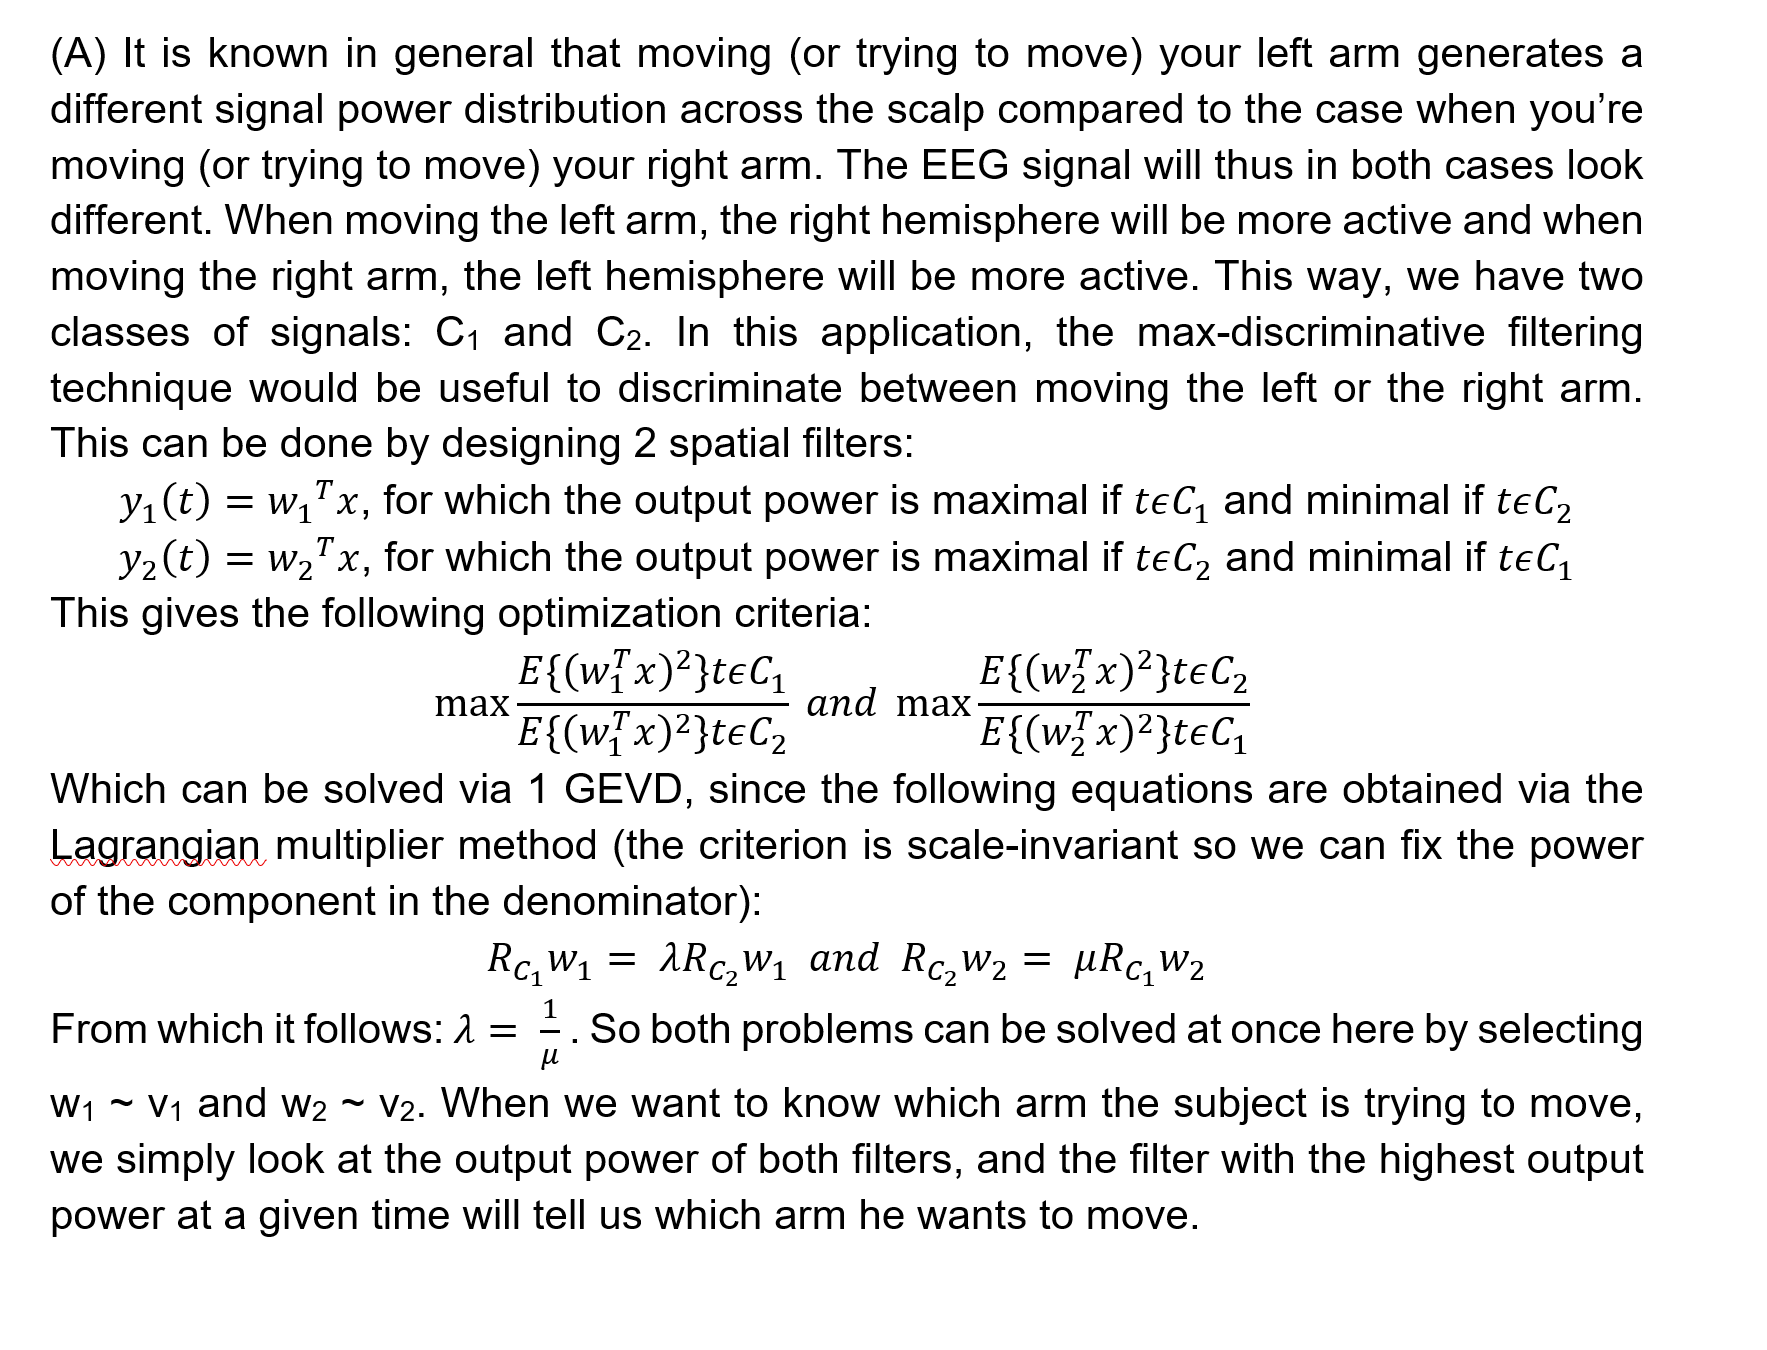

The information displayed in the above screenshot means that for our one GEVD problem formulation based on the joint diagonalization of the covariance matrices R1 and R2:
- selecting the eigenvector associated with a high eigenvalue as filter coefficients means that the output channel of that filter will yield a high variance for input signals in class 1 and a low variance for signals in class 2
- selecting the eigenvector associated with a low eigenvalue as filter coefficients means that the output channel of that filter will yield a high variance for input signals in class 2 and a low variance for signals in class 1

In our application, however, we're not going to retain any specific components of the GEVD yet. For now, we're just going to use all components, i.e. we're just gonna generate 64 different spatial filters based on the 64 different eigenvectors that can be generated from our data.

In [ ]:
from numpy import linalg

def cov(trials):
    ''' Calculate the covariance for each trial and return their average '''
    nsamples = trials.shape[1]
    ntrials = trials.shape[2]
    covs = [ trials[:,:,i].dot(trials[:,:,i].T) / nsamples for i in range(ntrials) ]
    return np.mean(covs, axis=0)

def whitening(sigma):
    ''' Calculate a whitening matrix for covariance matrix sigma. '''
    U, l, _ = linalg.svd(sigma)
    return U.dot( np.diag(l ** -0.5) )

def csp(trials_l, trials_r):
    '''
    Calculate the CSP transformation matrix W.
    arguments:
        trials_r - Array (channels x samples x trials) containing right hand movement trials
        trials_l - Array (channels x samples x trials) containing left hand movement trials
    returns:
        Mixing matrix W
    '''
    cov_r = cov(trials_r)
    cov_l = cov(trials_l)
    P = whitening(cov_r + cov_l)
    B, _, _ = linalg.svd( P.T.dot(cov_l).dot(P) )
    W = P.dot(B)
    return W

def apply_mix(W, trials):
    ''' Apply a mixing matrix to each trial (basically multiply W with the EEG signal matrix)'''
    nchannels = trials.shape[0]
    nsamples = trials.shape[1]
    ntrials = trials.shape[2]
    trials_csp = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
    return trials_csp


In [ ]:
# Estimation of W needs to happen on training data with annotations
# Otherwise, it's not possible
W = csp(X_ML[:,:,mask_0], X_ML[:,:,mask_1])
X_ML_CSP = apply_mix(W, X_ML)


In [ ]:
# Now, we visualize the average log-var of each CSP component output, repeating
# the comparison of differences between the channel log-vars of the 2 classes
trials_logvar = {cl1: logvar(X_ML_CSP[:,:,mask_0]),
                 cl2: logvar(X_ML_CSP[:,:,mask_1])}
plot_logvar(trials_logvar)


Instead of 64 channels, we now have 64 mixtures of channels, called components. They are, as previously explained, the result of 64 spatial filters being applied to the data. We can now see that the difference in the log-var of the 2 classes has indeed been increased by the CSP algorithm!

In [ ]:
# We can now also compare the class-specific mean PSD's at the output of the
# CSP component channels
psd_left, freqs = psd(X_ML_CSP[:,:,mask_0])
psd_right, freqs = psd(X_ML_CSP[:,:,mask_1])
trials_PSD = {cl1: psd_left, cl2: psd_right}


In [ ]:
plot_psd(trials_PSD, freqs, [0,31,-2], chan_lab=['first component', 'middle component', 'second to last component'], maxy=None)

Besides the logvar, it might be more discriminative to look at differences between some features of the PSD's of the two above-mentioned filter component outputs as well. We might derive more/multiple other features this way, such as e.g. PSD band power, PSD kurtosis/skew, peak amplitude,... etc., for each filter output in each trial/epoch.

In [ ]:
# First, we calculate the PSD of each CSP channel of each trial in X_ML_CSP
X_ML_CSP_PSD, freqs = psd(X_ML_CSP)


In [ ]:
# Write a function which can derive the desired features and which places
# them in a dataframe which can then be used by our machine learning classifier

from scipy.stats import kurtosis, skew
import pandas as pd

def extract_features(trials_PSDs, trials_time, CSP_components):

    component_1 = CSP_components[0]
    component_2 = CSP_components[1]

    df = pd.DataFrame(columns=['psd_power_1', 'psd_max_1', 'psd_kurtosis_1', 'psd_skew_1',
                               'psd_power_2', 'psd_max_2', 'psd_kurtosis_2', 'psd_skew_2',
                               'time_logvar_1', 'time_rms_1', 'time_kurtosis_1', 'time_skew_1',
                               'time_logvar_2', 'time_rms_2', 'time_kurtosis_2', 'time_skew_2'])
    for trial in range(trials_PSDs.shape[2]):
        psd_component_1 = trials_PSDs[component_1,:,trial][(freqs>=8) & (freqs<=15)]
        psd_component_2 = trials_PSDs[component_2,:,trial][(freqs>=8) & (freqs<=15)]

        power_1 = np.trapz(psd_component_1)
        power_2 = np.trapz(psd_component_2)
        max_1 = max(psd_component_1)
        max_2 = max(psd_component_2)
        kurtosis_1 = kurtosis(psd_component_1)
        kurtosis_2 = kurtosis(psd_component_2)
        skew_1 = skew(psd_component_1)
        skew_2 = skew(psd_component_2)

        time_component_1 = trials_time[component_1,:,trial]
        time_component_2 = trials_time[component_2,:,trial]

        logvar_1 = np.log(np.var(time_component_1))
        logvar_2 = np.log(np.var(time_component_2))
        rms_1 = np.sqrt(np.mean(np.square(time_component_1)))
        rms_2 = np.sqrt(np.mean(np.square(time_component_2)))
        time_kurtosis_1 = kurtosis(time_component_1)
        time_kurtosis_2 = kurtosis(time_component_2)
        time_skew_1 = skew(time_component_1)
        time_skew_2 = skew(time_component_2)

        row = [power_1, max_1, kurtosis_1, skew_1,
               power_2, max_2, kurtosis_2, skew_2,
               logvar_1, rms_1, time_kurtosis_1, time_skew_1,
               logvar_2, rms_2, time_kurtosis_2, time_skew_2]

        df.loc[len(df)] = row

    return df


In [ ]:
ML_features = extract_features(X_ML_CSP_PSD, X_ML_CSP, [0, -2])


In [ ]:
ML_features

In [ ]:
# Create subplots in a 1x2 grid
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

# Compare feature boxplots from class 1 and class 2
axs[0].boxplot(ML_features.loc[mask_0])
axs[0].set_title("Left")
axs[1].boxplot(ML_features.loc[mask_1])
axs[1].set_title("Right")

# Set y-axis label
for ax in axs.flat:
    ax.set(ylabel="Value")

# Add labels to the x-axis
for ax in axs.flat:
    ax.label_outer()

# Adjust layout for better appearance
plt.tight_layout()

# Show the boxplots
plt.show()

Now, we can really look towards training a machine learning classifier. But first, we will need to make a train-test split!

In [ ]:
from sklearn.model_selection import train_test_split

x = ML_features.copy()
y = y.copy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=87)

In [ ]:
print('Train set:')
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

print('Test set:')
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)


The dataset is also pretty balanced, so no oversampling is needed here.

Now, we can look towards actually training an algorithm!

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import time

# Reproducibility
RANDOM_SEED = 87

In [ ]:
def tune_train_test_pipeline(base_clf, clf_params, x_train, y_train, x_test, y_test):

    # Record the start time
    start_time = time.time()

    # Split the training data into 5 folds using cross-validation to tune hyperparameters
    cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

    # Use GridSearchCV to train the model for a given set of hyperparameter values
    # in clf_params and calculate the accuracy of each model to select the best
    # set of hyperparameters whilst using the cross-validation technique to
    # partition the validation data from the training data.
    tuned_clf = GridSearchCV(estimator=base_clf, param_grid=clf_params,
                              scoring=['accuracy'], refit='accuracy', cv=cv_splitter)

    # Fit the model on the training data
    tuned_clf.fit(x_train, y_train)

    # Best hyperparameters and cross-validation score
    print('Best hyperparameters: {}'.format(tuned_clf.best_params_))
    print("Best cross-validation score: {:.2f}".format(tuned_clf.best_score_))

    # Let the model predict on the train data and calculate the accuracy score
    prediction_train = tuned_clf.predict(x_train)
    accuracy_train = accuracy_score(y_train, prediction_train)

    # Let the model predict on the test data and calculate the accuracy score
    prediction_test = tuned_clf.predict(x_test)
    accuracy_test = accuracy_score(y_test, prediction_test)

    # Display model classification report for training data and test data
    print('Training Set: Classification report')
    print(classification_report(y_train, prediction_train))
    print('\nTest Set: Classification report')
    print(classification_report(y_test, prediction_test))

    # Define the class labels if you have them (optional)
    class_labels = ["left", "right"]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    cmap = plt.get_cmap('Blues')

    # Calculate and display the model's confusion matrix for the training data
    cm_train = confusion_matrix(y_train, prediction_train)
    display = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_labels)
    display.plot(ax=ax1, cmap=cmap)
    ax1.set_title('[Training Data] \nConfusion Matrix: tuned model')
    # Calculate and display the model's confusion matrix for the test data
    cm_test = confusion_matrix(y_test, prediction_test)
    display = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_labels)
    display.plot(ax=ax2, cmap=cmap)
    ax2.set_title('[Test Set] \nConfusion Matrix: tuned model')

    plt.tight_layout()
    plt.show()

    end_time = time.time()  # Record the end time
    training_time = end_time - start_time  # Calculate the training time
    training_time = training_time / 60 # Convert training time to minutes
    print("Processing time: {:.2f} minutes".format(training_time))

    return tuned_clf, [accuracy_train,accuracy_test], cm_train, cm_test, training_time


In [ ]:
base_clf = GBC()
clf_params = {
    'loss': ['log_loss', 'exponential'],  # The loss function to be optimized.
    'n_estimators': [25, 50, 100, 150, 200],  # The number of boosting stages (trees)
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],  # The step size shrinkage used to prevent overfitting
    'max_depth': [2, 3, 4, 5]}  # Maximum depth of the individual trees
tuned_gb, accuracy_gb, cm_train_gb, cm_test_gb, processing_gb_time = tune_train_test_pipeline(base_clf, clf_params, x_train, y_train, x_test, y_test)


Try PCA on the features and see if we can get better results

In [ ]:
# Normalize the feature matrix
df_features_normalized = (x - x.mean()) / x.std()

# Calculate the covariance matrix
cov_matrix = np.cov(df_features_normalized, rowvar=False)

# Calculate the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Select an adequate number of PC's
num_pcs = 9
selected_eigenvectors = eigenvectors[:, :num_pcs]

# Project the feature matrix onto the selected eigenvectors
pca_features = np.dot(selected_eigenvectors.T, df_features_normalized.T).T
pca_features = np.real(pca_features)

# Convert the 2D array back to a dataframe
df_pca = pd.DataFrame(pca_features)


In [ ]:
sorted_eigenvalues = np.sort(eigenvalues)[::-1]
plt.figure() # Create a new figure
plt.plot(sorted_eigenvalues) # Plot the sorted eigenvalues
plt.title('Sorted Eigenvalues') # Set the title of the plot
plt.ylabel('Eigenvalue') # Label the y-axis
plt.show() # Display the plot


In [ ]:
df_pca


In [ ]:
x_pca = df_pca.copy()

x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_pca, y, test_size=0.2,
                                                                    stratify=y,
                                                                    shuffle=True,
                                                                    random_state=87)


In [ ]:
print('Train set:')
unique, counts = np.unique(y_train_pca, return_counts=True)
print(np.asarray((unique, counts)).T)

print('Test set:')
unique, counts = np.unique(y_test_pca, return_counts=True)
print(np.asarray((unique, counts)).T)


In [ ]:
tuned_gb, accuracy_gb, cm_train_gb, cm_test_gb, processing_gb_time = tune_train_test_pipeline(base_clf, clf_params, x_train_pca, y_train_pca, x_test_pca, y_test_pca)


Try feature normalisation to see if we get better results

In [ ]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler().fit(x_train)

x_scale_train = x_scaler.transform(x_train)
x_scale_test  = x_scaler.transform(x_test)


In [ ]:
# Create subplots in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Compare x_train and x_scale_train
axs[0, 0].boxplot(x_train)
axs[0, 0].set_title("x_train")
axs[0, 1].boxplot(x_scale_train)
axs[0, 1].set_title("x_scale_train")

# Compare x_test and x_scale_test
axs[1, 0].boxplot(x_test)
axs[1, 0].set_title("x_test")
axs[1, 1].boxplot(x_scale_test)
axs[1, 1].set_title("x_scale_test")

# Set y-axis label
for ax in axs.flat:
    ax.set(ylabel="Value")

# Add labels to the x-axis
for ax in axs.flat:
    ax.label_outer()

# Adjust layout for better appearance
plt.tight_layout()

# Show the boxplots
plt.show()

In [ ]:
tuned_gb, accuracy_gb, cm_train_gb, cm_test_gb, processing_gb_time = tune_train_test_pipeline(base_clf, clf_params, x_scale_train, y_train, x_scale_test, y_test)


## Deep Learning approach

Here, we can prepare the data for usage in DL models

In [27]:
class EEGDataset(data.Dataset):
    def __init__(self, x, y=None, inference=False):
        super().__init__()

        N_SAMPLE = x.shape[0]
        val_idx = int(0.9 * N_SAMPLE)
        train_idx = int(0.81 * N_SAMPLE)

        if not inference:
            self.train_ds = {
                'x': x[:train_idx],
                'y': y[:train_idx],
            }
            self.val_ds = {
                'x': x[train_idx:val_idx],
                'y': y[train_idx:val_idx],
            }
            self.test_ds = {
                'x': x[val_idx:],
                'y': y[val_idx:],
            }
        else:
            self.__split = "inference"
            self.inference_ds = {
                'x': [x],
            }

    def __len__(self):
        return len(self.dataset['x'])

    def __getitem__(self, idx):

        x = self.dataset['x'][idx]
        if self.__split != "inference":
            y = self.dataset['y'][idx]
            x = torch.tensor(x).float()
            y = torch.tensor(y).unsqueeze(-1).float()
            return x, y
        else:
            x = torch.tensor(x).float()
            return x

    def split(self, __split):
        self.__split = __split
        return self

    @classmethod
    def inference_dataset(cls, x):
        return cls(x, inference=True)

    @property
    def dataset(self):
        assert self.__split is not None, "Please specify the split of dataset!"

        if self.__split == "train":
            return self.train_ds
        elif self.__split == "val":
            return self.val_ds
        elif self.__split == "test":
            return self.test_ds
        elif self.__split == "inference":
            return self.inference_ds
        else:
            raise TypeError("Unknown type of split!")


In [28]:
eeg_dataset = EEGDataset(x=X_DL, y=y)


Now, we will define different components of our DL pipeline.

In [29]:
class AvgMeter(object):
    def __init__(self, num=40):
        self.num = num
        self.reset()

    def reset(self):
        self.losses = []

    def update(self, val):
        self.losses.append(val)

    def show(self):
        out = torch.mean(
            torch.stack(
                self.losses[np.maximum(len(self.losses)-self.num, 0):]
            )
        )
        return out


class ModelWrapper(L.LightningModule):
    def __init__(self, arch, dataset, batch_size, lr, max_epoch):
        super().__init__()

        self.arch = arch
        self.dataset = dataset
        self.batch_size = batch_size
        self.lr = lr
        self.max_epoch = max_epoch

        self.train_accuracy = Accuracy(task="binary")
        self.val_accuracy = Accuracy(task="binary")
        self.test_accuracy = Accuracy(task="binary")

        self.automatic_optimization = False

        self.train_loss = []
        self.val_loss = []

        self.train_acc = []
        self.val_acc = []

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_acc_recorder = AvgMeter()
        self.val_acc_recorder = AvgMeter()

    def forward(self, x):
        return self.arch(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        self.train_accuracy.update(y_hat, y)
        acc = self.train_accuracy.compute().data.cpu()

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.train_loss_recorder.update(loss.data)
        self.train_acc_recorder.update(acc)

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

    def on_train_epoch_end(self):
        sch = self.lr_schedulers()
        sch.step()

        self.train_loss.append(self.train_loss_recorder.show().data.cpu().numpy())
        self.train_loss_recorder = AvgMeter()

        self.train_acc.append(self.train_acc_recorder.show().data.cpu().numpy())
        self.train_acc_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        self.val_accuracy.update(y_hat, y)
        acc = self.val_accuracy.compute().data.cpu()

        self.val_loss_recorder.update(loss.data)
        self.val_acc_recorder.update(acc)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def on_validation_epoch_end(self):
        self.val_loss.append(self.val_loss_recorder.show().data.cpu().numpy())
        self.val_loss_recorder = AvgMeter()

        self.val_acc.append(self.val_acc_recorder.show().data.cpu().numpy())
        self.val_acc_recorder = AvgMeter()

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        self.test_accuracy.update(y_hat, y)

        self.log(
            "test_loss",
            loss,
            prog_bar=True,
            logger=True,
        )
        self.log(
            "test_acc",
            self.test_accuracy.compute(),
            prog_bar=True,
            logger=True,
        )

    def on_train_end(self):

        # Loss
        loss_img_file = "/content/loss_plot.png"
        plt.plot(self.train_loss, color = 'r', label='train')
        plt.plot(self.val_loss, color = 'b', label='validation')
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        # Accuracy
        acc_img_file = "/content/acc_plot.png"
        plt.plot(self.train_acc, color = 'r', label='train')
        plt.plot(self.val_acc, color = 'b', label='validation')
        plt.title("Accuracy Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.savefig(acc_img_file)
        plt.clf()
        img = cv2.imread(acc_img_file)
        cv2_imshow(img)

    def train_dataloader(self):
        return data.DataLoader(
            dataset=self.dataset.split("train"),
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=self.dataset.split("val"),
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=self.dataset.split("test"),
            batch_size=1,
            shuffle=False,
        )

    def configure_optimizers(self):

        optimizer = optim.Adam(
            self.parameters(),
            lr=self.lr,
        )
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.MultiStepLR(
                optimizer,
                milestones=[
                    int(self.max_epoch * 0.25),
                    int(self.max_epoch * 0.5),
                    int(self.max_epoch * 0.75),
                ],
                gamma=0.1
            ),
            "name": "lr_scheduler",
        }
        return [optimizer], [lr_scheduler]



**TRANSFORMER MODEL 1**: The below defined model architecture is based on the following repo:

https://github.com/reshalfahsi/eeg-motor-imagery-classification/tree/master

In [ ]:
class PositionalEncoding(nn.Module):
    """Positional encoding.
    https://d2l.ai/chapter_attention-mechanisms-and-transformers/self-attention-and-positional-encoding.html
    """
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.p = torch.zeros((1, max_len, num_hiddens))
        x = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.p[:, :, 0::2] = torch.sin(x)
        self.p[:, :, 1::2] = torch.cos(x)

    def forward(self, x):
        x = x + self.p[:, :x.shape[1], :].to(x.device)
        return self.dropout(x)


class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dim_feedforward, dropout=0.1):
        super().__init__()

        self.attention = nn.MultiheadAttention(
            embed_dim,
            num_heads,
            dropout,
            batch_first=True,
        )
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, dim_feedforward),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, embed_dim),
        )

        self.layernorm0 = nn.LayerNorm(embed_dim)
        self.layernorm1 = nn.LayerNorm(embed_dim)

        self.dropout = dropout

    def forward(self, x):
        y, att = self.attention(x, x, x)
        y = F.dropout(y, self.dropout, training=self.training)
        x = self.layernorm0(x + y)
        y = self.mlp(x)
        y = F.dropout(y, self.dropout, training=self.training)
        x = self.layernorm1(x + y)
        return x


class EEGClassificationModel(nn.Module):
    def __init__(self, eeg_channel, dropout=0.1):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(
                eeg_channel, eeg_channel, 11, 1, padding=5, bias=False
            ),
            nn.BatchNorm1d(eeg_channel),
            nn.ReLU(True),
            nn.Dropout1d(dropout),
            nn.Conv1d(
                eeg_channel, eeg_channel * 2, 11, 1, padding=5, bias=False
            ),
            nn.BatchNorm1d(eeg_channel * 2),
        )

        self.transformer = nn.Sequential(
            PositionalEncoding(eeg_channel * 2, dropout),
            TransformerBlock(eeg_channel * 2, 4, eeg_channel // 8, dropout),
            TransformerBlock(eeg_channel * 2, 4, eeg_channel // 8, dropout),
        )

        self.mlp = nn.Sequential(
            nn.Linear(eeg_channel * 2, eeg_channel // 2),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(eeg_channel // 2, 1),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.permute(0, 2, 1)
        x = self.transformer(x)
        x = x.permute(0, 2, 1)
        x = x.mean(dim=-1)
        x = self.mlp(x)
        return x


In [ ]:
MODEL_NAME = "EEGClassificationModel"
model = EEGClassificationModel(eeg_channel=int(X_DL.shape[1]), dropout=0.125)


Here, we can start training

In [ ]:
MAX_EPOCH = 100
BATCH_SIZE = 10
LR = 5e-4
CHECKPOINT_DIR = os.getcwd()
SEED = 87

print(f"Random seed: {SEED}")

model = ModelWrapper(model, eeg_dataset, BATCH_SIZE, LR, MAX_EPOCH)

!rm -rf logs/


Random seed: 87


**TRANSFORMER MODEL 2**: The below defined model architecture is based on feedback from E.S.A.I.V. Serpentine and the following repo:

https://github.com/eeyhsong/EEG-Conformer/tree/main

In [30]:
class ComfyNet(nn.Module):
    """Convolutional Transformer for EEG decoding.

    The paper and original code with more details about the methodological
    choices are available at the [Song2022]_ and [ConformerCode]_.

    This neural network architecture receives a traditional braindecode input.
    The input shape should be three-dimensional matrix representing the EEG
    signals.

         `(batch_size, n_channels, n_timesteps)`.

    The EEG Conformer architecture is composed of three modules:
        - PatchEmbedding
        - TransformerEncoder
        - ClassificationHead

    Notes
    -----
    The authors recommend using data augmentation before using Conformer,
    e.g. segmentation and recombination,
    Please refer to the original paper and code for more details.

    The model was initially tuned on 4 seconds of 250 Hz data.
    Please adjust the scale of the temporal convolutional layer,
    and the pooling layer for better performance.

    We aggregate the parameters based on the parts of the models, or
    when the parameters were used first, e.g. n_filters_time.

    Parameters
    ----------
    n_filters_time: int
        Number of temporal filters, defines also embedding size.
    filter_time_length: int
        Length of the temporal filter.
    pool_time_length: int
        Length of temporal pooling filter.
    pool_time_stride: int
        Length of stride between temporal pooling filters.
    drop_prob: float
        Dropout rate of the convolutional layer.
    att_depth: int
        Number of self-attention layers.
    att_heads: int
        Number of attention heads.
    return_features: bool
        If True, the forward method returns the features before the
        last classification layer. Defaults to False.
    References
    ----------
    .. [Song2022] Song, Y., Zheng, Q., Liu, B. and Gao, X., 2022. EEG
       conformer: Convolutional transformer for EEG decoding and visualization.
       IEEE Transactions on Neural Systems and Rehabilitation Engineering,
       31, pp.710-719. https://ieeexplore.ieee.org/document/9991178
    .. [ConformerCode] Song, Y., Zheng, Q., Liu, B. and Gao, X., 2022. EEG
       conformer: Convolutional transformer for EEG decoding and visualization.
       https://github.com/eeyhsong/EEG-Conformer.
    """

    def __init__(
        self,
        n_outputs=None,
        n_chans=None,
        n_filters_time=40,
        filter_time_length=25,
        pool_time_length=75,
        pool_time_stride=15,
        drop_prob=0.5,
        att_depth=2,
        att_heads=4,
        n_times=None,
        return_features=False,
    ):
        super().__init__()

        self.n_outputs = n_outputs
        self.n_chans = n_chans
        self.n_times = n_times


        self.mapping = {
            "classification_head.fc.6.weight": "final_layer.final_layer.0.weight",
            "classification_head.fc.6.bias": "final_layer.final_layer.0.bias",
        }

        if not (self.n_chans <= 64):
            warnings.warn(
                "This model has only been tested on no more "
                + "than 64 channels. no guarantee to work with "
                + "more channels.",
                UserWarning,
            )

        self.patch_embedding = _PatchEmbedding(
            n_filters_time=n_filters_time,
            filter_time_length=filter_time_length,
            n_channels=n_chans,
            pool_time_length=pool_time_length,
            stride_avg_pool=pool_time_stride,
            drop_prob=drop_prob,
        )

        self.positional_encoding = PositionalEncoding(
            n_filters_time,
            n_times,
        )

        final_fc_length = self.get_fc_size()


        self.tranformer_layer = nn.TransformerEncoderLayer(d_model=n_filters_time, nhead=att_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(self.tranformer_layer, num_layers=att_depth)


        self.fc = _FullyConnected(final_fc_length=final_fc_length)

        self.final_layer = _FinalLayer(
            n_classes=self.n_outputs,
            return_features=return_features,
        )

    def forward(self, x: Tensor) -> Tensor:
        x = torch.unsqueeze(x, dim=1)  # add one extra dimension
        x = self.patch_embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer(x)
        x = self.fc(x)
        x = self.final_layer(x)
        return x

    def get_fc_size(self):
        out = self.patch_embedding(torch.ones((1, 1, self.n_chans, self.n_times)))
        size_embedding_1 = out.cpu().data.numpy().shape[1]
        size_embedding_2 = out.cpu().data.numpy().shape[2]

        return size_embedding_1 * size_embedding_2


class _PatchEmbedding(nn.Module):
    """Patch Embedding.

    The authors used a convolution module to capture local features,
    instead of position embedding.

    Parameters
    ----------
    n_filters_time: int
        Number of temporal filters, defines also embedding size.
    filter_time_length: int
        Length of the temporal filter.
    n_channels: int
        Number of channels to be used as number of spatial filters.
    pool_time_length: int
        Length of temporal poling filter.
    stride_avg_pool: int
        Length of stride between temporal pooling filters.
    drop_prob: float
        Dropout rate of the convolutional layer.

    Returns
    -------
    x: torch.Tensor
        The output tensor of the patch embedding layer.
    """

    def __init__(
        self,
        n_filters_time,
        filter_time_length,
        n_channels,
        pool_time_length,
        stride_avg_pool,
        drop_prob,
    ):
        super().__init__()

        self.shallownet = nn.Sequential(
            nn.Conv2d(1, n_filters_time, (1, filter_time_length), (1, 1)),
            nn.Conv2d(n_filters_time, n_filters_time, (n_channels, 1), (1, 1)),
            nn.BatchNorm2d(num_features=n_filters_time),
            nn.ELU(),
            nn.AvgPool2d(
                kernel_size=(1, pool_time_length), stride=(1, stride_avg_pool)
            ),
            # pooling acts as slicing to obtain 'patch' along the
            # time dimension as in ViT
            nn.Dropout(p=drop_prob),
        )

        self.projection = nn.Sequential(
            nn.Conv2d(
                n_filters_time, n_filters_time, (1, 1), stride=(1, 1)
            ),  # transpose, conv could enhance fitting ability slightly
            Rearrange("b d_model 1 seq -> b seq d_model"),
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.shallownet(x)
        x = self.projection(x)
        return x


class PositionalEncoding(torch.nn.Module):
    def __init__(self, emb_size, max_len):
        super(PositionalEncoding, self).__init__()

        # Create a long enough `pe` matrix with shape (max_len, d_model)
        pe = torch.zeros(max_len, emb_size)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, emb_size, 2).float() * (-math.log(10000.0) / emb_size)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0).transpose(0, 1)  # Shape (max_len, 1, d_model)
        self.register_buffer(
            "pe", pe
        )  # Not a trainable parameter but buffered for state tracking

    def forward(self, x):
        # `x` shape: (sequence_length, batch_size, d_model)
        return x + self.pe[: x.size(0), :]



class _FullyConnected(nn.Module):
    def __init__(
        self,
        final_fc_length,
        drop_prob_1=0.5,
        drop_prob_2=0.3,
        out_channels=256,
        hidden_channels=32,
    ):
        """Fully-connected layer for the transformer encoder.

        Parameters
        ----------
        final_fc_length : int
            Length of the final fully connected layer.
        drop_prob_1 : float
            Dropout probability for the first dropout layer.
        drop_prob_2 : float
            Dropout probability for the second dropout layer.
        out_channels : int
            Number of output channels for the first linear layer.
        hidden_channels : int
            Number of output channels for the second linear layer.
        """

        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(final_fc_length, out_channels),
            nn.ELU(),
            nn.Dropout(drop_prob_1),
            nn.Linear(out_channels, hidden_channels),
            nn.ELU(),
            nn.Dropout(drop_prob_2),
        )

    def forward(self, x):
        x = x.contiguous().view(x.size(0), -1)
        out = self.fc(x)
        return out


class _FinalLayer(nn.Module):
    def __init__(
            self, n_classes, hidden_channels=32, return_features=False
    ):
        """Classification head for the transformer encoder.

        Parameters
        ----------
        n_classes : int
            Number of classes for classification.
        hidden_channels : int
            Number of output channels for the second linear layer.
        return_features : bool
            Whether to return input features.
        """

        super().__init__()
        self.final_layer = nn.Sequential(
            nn.Linear(hidden_channels, n_classes),
        )
        self.return_features = return_features

        # WARNING : The original code uses a custom loss function
        # classification = nn.CrossEntropyLoss()
        #
        # if not self.return_features:
        #     self.final_layer.add_module("classification", classification)

    def forward(self, x):
        if self.return_features:
            out = self.final_layer(x)
            return out, x
        else:
            out = self.final_layer(x)
            return out


In [36]:
MODEL_NAME = "ComfyNet"
# model = ComfyNet(n_outputs=len(CLASSES), n_chans=int(X_DL.shape[1]), n_times=int(X_DL.shape[2]))
model = ComfyNet(n_outputs=1, n_chans=int(X_DL.shape[1]), n_times=int(X_DL.shape[2]))


Here, we can start training

In [37]:
MAX_EPOCH = 2000
BATCH_SIZE = 72
LR = 2e-4
CHECKPOINT_DIR = os.getcwd()
SEED = 87

print(f"Random seed: {SEED}")

model = ModelWrapper(model, eeg_dataset, BATCH_SIZE, LR, MAX_EPOCH)

!rm -rf logs/

Random seed: 87


**Continue here independent of which model you're using**

INFO: Seed set to 87
INFO:lightning.fabric.utilities.seed:Seed set to 87
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type                   | Params
----------------------------------------------------------
0 | arch           | EEGClassificationModel | 277 K 
1 | train_accuracy | BinaryAccuracy         | 0     
2 | val_accuracy   | BinaryAccuracy         | 0     
3 | test_accuracy 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


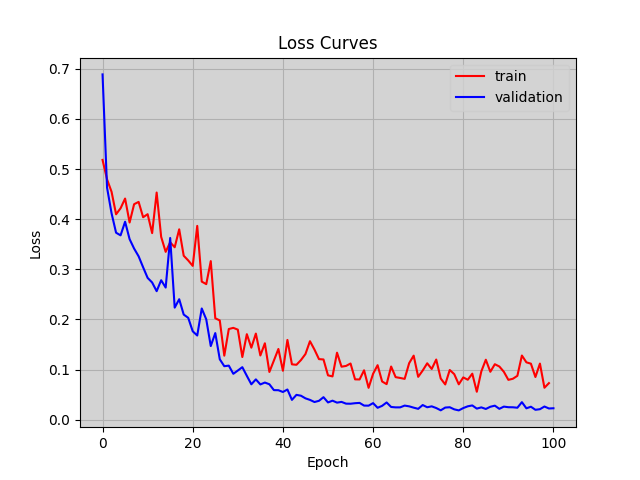

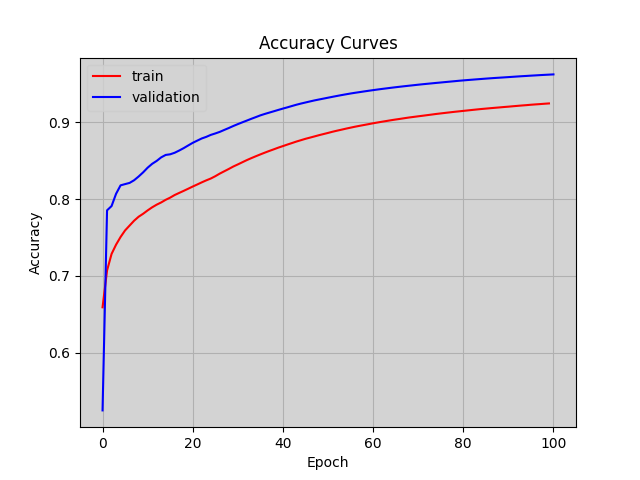

<Figure size 640x480 with 0 Axes>

In [ ]:
# Model 1
tensorboardlogger = TensorBoardLogger(save_dir="logs/")
csvlogger = CSVLogger(save_dir="logs/")
lr_monitor = LearningRateMonitor(logging_interval='step')
checkpoint = ModelCheckpoint(
    monitor='val_acc',
    dirpath=CHECKPOINT_DIR,
    mode='max',
)
early_stopping = EarlyStopping(
    monitor="val_acc", min_delta=0.00, patience=3, verbose=False, mode="max"
)


seed_everything(SEED, workers=True)


trainer = Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=MAX_EPOCH,
    logger=[tensorboardlogger, csvlogger],
    callbacks=[lr_monitor, checkpoint, early_stopping],
    log_every_n_steps=5,
)
trainer.fit(model)


Here, we can start testing

In [ ]:
trainer.test(ckpt_path="best")

os.rename(
    checkpoint.best_model_path,
    os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt")
)


INFO: Restoring states from the checkpoint path at /content/epoch=99-step=38300.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/epoch=99-step=38300.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/epoch=99-step=38300.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/epoch=99-step=38300.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7081871032714844     │
│         test_loss         │    0.9763309359550476     │
└───────────────────────────┴───────────────────────────┘

INFO: Seed set to 87
INFO:lightning.fabric.utilities.seed:Seed set to 87
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type           | Params
--------------------------------------------------
0 | arch           | ComfyNet       | 785 K 
1 | train_accuracy | BinaryAccuracy | 0     
2 | val_accuracy   | BinaryAccuracy | 0     
3 | test_accuracy  | BinaryAccuracy | 0     
-------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

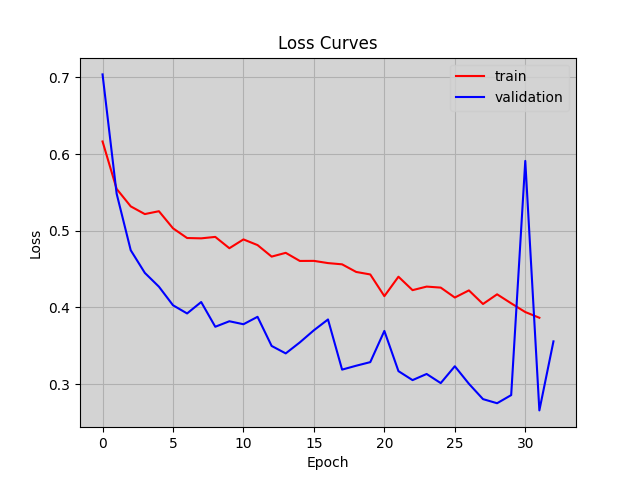

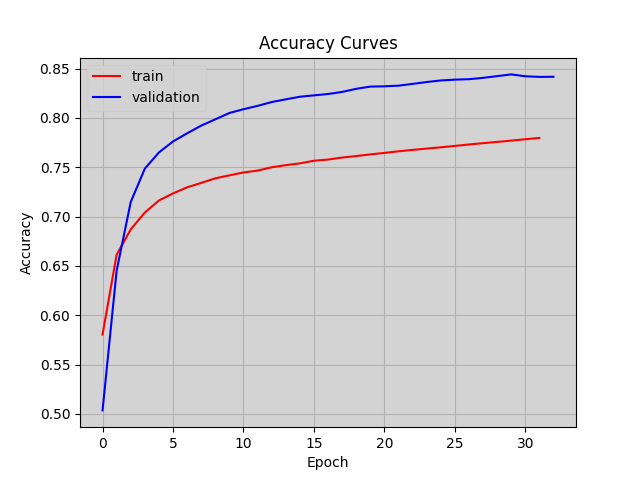

<Figure size 640x480 with 0 Axes>

In [38]:
# Model 2
tensorboardlogger = TensorBoardLogger(save_dir="logs/")
csvlogger = CSVLogger(save_dir="logs/")
lr_monitor = LearningRateMonitor(logging_interval='step')
checkpoint = ModelCheckpoint(
    monitor='val_acc',
    dirpath=CHECKPOINT_DIR,
    mode='max',
)
early_stopping = EarlyStopping(
    monitor="val_acc", min_delta=0.00, patience=3, verbose=False, mode="max"
)


seed_everything(SEED, workers=True)


trainer = Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=MAX_EPOCH,
    logger=[tensorboardlogger, csvlogger],
    callbacks=[lr_monitor, checkpoint, early_stopping],
    log_every_n_steps=5,
)
trainer.fit(model)


Here, we can start testing

In [39]:
trainer.test(ckpt_path="best")

os.rename(
    checkpoint.best_model_path,
    os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt")
)


INFO: Restoring states from the checkpoint path at /content/epoch=28-step=1566.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/epoch=28-step=1566.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/epoch=28-step=1566.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/epoch=28-step=1566.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8052123785018921     │
│         test_loss         │    0.4675629138946533     │
└───────────────────────────┴───────────────────────────┘

Possible idea for deep larning as well:

Look into using a pre-trained raw EEG feature extractor network, that can be used to train an ML classifier? Similar to the asbestos project of Sentigrate

https://www.sciencedirect.com/science/article/pii/S0957417422019194

https://github.com/arkanivasarkar/EEG-Data-Augmentation-using-Variational-Autoencoder

## Load the BCICIV dataset (1 continuous recording of 1 subject)

In [ ]:
!unzip "drive/MyDrive/Colab Notebooks/BCICIV_1_mat.zip"


In [ ]:
import scipy.io
import numpy as np

m = scipy.io.loadmat('BCICIV_calib_ds1d.mat', struct_as_record=True)

# SciPy.io.loadmat does not deal well with Matlab structures, resulting in lots of
# extra dimensions in the arrays. This makes the code a bit more cluttered

sample_rate = m['nfo']['fs'][0][0][0][0]
EEG = m['cnt'].T
nchannels, nsamples = EEG.shape

channel_names = [s[0] for s in m['nfo']['clab'][0][0][0]]
event_onsets = m['mrk'][0][0][0]
event_codes = m['mrk'][0][0][1]
labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in m['nfo']['classes'][0][0][0]]
CLASSES = cl_lab
cl1 = cl_lab[0]
cl2 = cl_lab[1]
nclasses = len(cl_lab)
nevents = len(event_onsets)


In [ ]:
# Print some information
print('Shape of EEG:', EEG.shape)
print('Sample rate:', sample_rate)
print('Number of channels:', nchannels)
print('Channel names:', channel_names)
print('Number of events:', len(event_onsets))
print('Event codes:', np.unique(event_codes))
print('Class labels:', cl_lab)
print('Number of classes:', nclasses)


For this recording 59 electrodes where used, spread across the entire scalp. The subject was given a cue and then imagined either right hand movement or the movement of his feet. Here, we will skip the general filtering preprocessing steps, as they're not really necessary anyway if we're going to apply a bandpass filter with cut-off freqs 8 Hz and 15 Hz for the feature extraction anyway. Of course, in our final, complete pipeline, we should first apply the general pre-processing bandpass filter in order to have a preprocessing consensus with the emotions team.

The code below cuts trials for the two classes. Trials are cut in the interval [0.5–2.5 s] after the onset of the cue.

In [ ]:
# Dictionary to store the trials in, each class gets an entry
trials = {}

# The time window (in samples) to extract for each trial, here 0.5 -- 2.5 seconds
win = np.arange(int(0.5*sample_rate), int(2.5*sample_rate))

# Length of the time window
nsamples = len(win)

# Loop over the classes (right, foot)
for cl, code in zip(cl_lab, np.unique(event_codes)):

    # Extract the onsets for the class
    cl_onsets = event_onsets[event_codes == code]

    # Allocate memory for the trials
    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))

    # Extract each trial
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEG[:, win+onset]

# Some information about the dimensionality of the data (channels x time x trials)
print('Shape of trials[cl1]:', trials[cl1].shape)
print('Shape of trials[cl2]:', trials[cl2].shape)


Since the features we're looking for (a decrease in $\mu$-activity) are frequency features, let's plot the PSD of the trials in a similar manner as before.

In [ ]:
psd_left, freqs = psd(trials[cl1])
psd_right, freqs = psd(trials[cl2])
trials_PSD = {cl1: psd_left, cl2: psd_right}


In [ ]:
import matplotlib.pyplot as plt

plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3', 'Cz', 'C4']],
    chan_lab=['left', 'center', 'right'],
    maxy=500
)


Again, we will bandpass the signal to obtain the frequency information between 8-15 Hz for the feature extraction later on

In [ ]:
trials_filt = {cl1: bandpass(trials[cl1], 8, 15, sample_rate),
               cl2: bandpass(trials[cl2], 8, 15, sample_rate)}


Check the PSD's of the results

In [ ]:
psd_left, freqs = psd(trials_filt[cl1])
psd_right, freqs = psd(trials_filt[cl2])
trials_PSD = {cl1: psd_left, cl2: psd_right}

plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3', 'Cz', 'C4']],
    chan_lab=['left', 'center', 'right'],
    maxy=150
)


Again, as a feature for the classifier later on, we will look into the logarithm of the variance of each EEG channel. We will again design a CSP filter which will enhance the difference in variance between our two classes. Afterwards, we can then again choose if we want to stick with the log-var as our feature or if we want to turn towards PSD features of the CSP filter outputs.

In [ ]:
trials_logvar = {cl1: logvar(trials_filt[cl1]),
                 cl2: logvar(trials_filt[cl2])}


In [ ]:
plot_logvar(trials_logvar)


In [ ]:
W = csp(trials_filt[cl1], trials_filt[cl2])
trials_csp = {cl1: apply_mix(W, trials_filt[cl1]),
              cl2: apply_mix(W, trials_filt[cl2])}


In [ ]:
trials_logvar = {cl1: logvar(trials_csp[cl1]),
                 cl2: logvar(trials_csp[cl2])}
plot_logvar(trials_logvar)


Here, we immidiately see that our CSP approach shows better separability of the two classes than for the Physionet dataset! Maybe here, the log-var will be good enough of a feature to perform classification! Let's first also visualize the mean PSD's of the two classes in some of the CSP component outputs.

In [ ]:
psd_left, freqs = psd(trials_csp[cl1])
psd_right, freqs = psd(trials_csp[cl2])
trials_PSD = {cl1: psd_left, cl2: psd_right}

plot_psd(trials_PSD, freqs, [0,29,-1], chan_lab=['first component', 'middle component', 'last component'], maxy=0.75 )


In order to see how well we can differentiate between the two classes purely based on the log-var alone, to see if now the log-var alone would suffice for classification purposes, a scatter plot is a useful tool. Here both classes are plotted on a 2-dimensional plane: the x-axis is the first CSP component, the y-axis is the last.

In [ ]:
def plot_scatter(left, foot):
    plt.figure()
    plt.scatter(left[0,:], left[-1,:], color='b')
    plt.scatter(foot[0,:], foot[-1,:], color='r')
    plt.xlabel('Last component')
    plt.ylabel('First component')
    plt.legend(cl_lab)


In [ ]:
plot_scatter(trials_logvar[cl1], trials_logvar[cl2])


This time the log-var seems to be good enough of a feature for an ML classifier! Let's try to implement one in the time domain this time...

The data is split into a train and a test set. The classifier will fit a model (in this case, a straight line) on the training set and use this model to make predictions about the test set (see on which side of the line each trial in the test set falls). Note that the CSP algorithm is part of the model, so for fairness sake it should be calculated using only the training data.

In [ ]:
# Percentage of trials to use for training (50-50 split here)
train_percentage = 0.5

# Calculate the number of trials for each class the above percentage boils down to
ntrain_left = int(trials_filt[cl1].shape[2] * train_percentage)
ntrain_right = int(trials_filt[cl2].shape[2] * train_percentage)
ntest_left = trials_filt[cl1].shape[2] - ntrain_left
ntest_right = trials_filt[cl2].shape[2] - ntrain_right

# Splitting the frequency filtered signal into a train and test set
train = {cl1: trials_filt[cl1][:,:,:ntrain_left],
         cl2: trials_filt[cl2][:,:,:ntrain_right]}

test = {cl1: trials_filt[cl1][:,:,ntrain_left:],
        cl2: trials_filt[cl2][:,:,ntrain_right:]}

# Train the CSP on the training set only
W = csp(train[cl1], train[cl2])

# Apply the CSP on both the training and test set
train[cl1] = apply_mix(W, train[cl1])
train[cl2] = apply_mix(W, train[cl2])
test[cl1] = apply_mix(W, test[cl1])
test[cl2] = apply_mix(W, test[cl2])

# Select only the first and last components for classification
comp = np.array([0,-1])
train[cl1] = train[cl1][comp,:,:]
train[cl2] = train[cl2][comp,:,:]
test[cl1] = test[cl1][comp,:,:]
test[cl2] = test[cl2][comp,:,:]

# Calculate the log-var
train[cl1] = logvar(train[cl1])
train[cl2] = logvar(train[cl2])
test[cl1] = logvar(test[cl1])
test[cl2] = logvar(test[cl2])


For a classifier the Linear Discriminant Analysis (LDA) algorithm will be used. It fits a gaussian distribution to each class, characterized by the mean and covariance, and determines an optimal separating plane to divide the two. This plane is defined as $r = W_0 \cdot X_0 + W_1 \cdot X_1 + \ldots + W_n \cdot X_n - b$, where $r$ is the classifier output, $W$ are called the feature weights, $X$ are the features of the trial, $n$ is the dimensionality of the data and $b$ is called the offset.

In our case we have 2 dimensional data, so the separating plane will be a line: $r = W_0 \cdot X_0 + W_1 \cdot X_1 - b$. To determine a class label for an unseen trial, we can calculate whether the result is positive or negative.

In [ ]:
def train_lda(class1, class2):
    '''
    Trains the LDA algorithm.
    arguments:
        class1 - An array (observations x features) for class 1
        class2 - An array (observations x features) for class 2
    returns:
        The projection matrix W
        The offset b
    '''
    nclasses = 2

    nclass1 = class1.shape[0]
    nclass2 = class2.shape[0]

    # Class priors: in this case, we have an equal number of training
    # examples for each class, so both priors are 0.5
    prior1 = nclass1 / float(nclass1 + nclass2)
    prior2 = nclass2 / float(nclass1 + nclass1)

    mean1 = np.mean(class1, axis=0)
    mean2 = np.mean(class2, axis=0)

    class1_centered = class1 - mean1
    class2_centered = class2 - mean2

    # Calculate the covariance between the features
    cov1 = class1_centered.T.dot(class1_centered) / (nclass1 - nclasses)
    cov2 = class2_centered.T.dot(class2_centered) / (nclass2 - nclasses)

    W = (mean2 - mean1).dot(np.linalg.pinv(prior1*cov1 + prior2*cov2))
    b = (prior1*mean1 + prior2*mean2).dot(W)

    return (W,b)

def apply_lda(test, W, b):
    '''
    Applies a previously trained LDA to new data.
    arguments:
        test - An array (features x trials) containing the data
        W    - The project matrix W as calculated by train_lda()
        b    - The offsets b as calculated by train_lda()
    returns:
        A list containing a classlabel for each trial
    '''
    ntrials = test.shape[1]

    prediction = []
    for i in range(ntrials):
        # The line below is a generalization for:
        # result = W[0] * test[0,i] + W[1] * test[1,i] - b
        result = W.dot(test[:,i]) - b
        if result <= 0:
            prediction.append(1)
        else:
            prediction.append(2)

    return np.array(prediction)


In [ ]:
W,b = train_lda(train[cl1].T, train[cl2].T)

print('W:', W)
print('b:', b)


It can be informative to recreate the scatter plot and overlay the decision boundary as determined by the LDA classifier. The decision boundary is the line for which the classifier output is exactly 0. The scatterplot used $X_0$ as $x$-axis and $X_1$ as $y$-axis. To find the function $y = f(x)$ describing the decision boundary, we set $r$ to 0 and solve for $y$ in the equation of the separating plane:

$$\begin{align} W_0 \cdot X_0 + W_1 \cdot X_1 - b &= r &&\text{the original equation} \\\ W_0 \cdot x + W_1 \cdot y - b &= 0 &&\text{filling in $X_0=x$, $X_1=y$ and $r=0$} \\\ W_0 \cdot x + W_1 \cdot y &= b &&\text{solving for $y$}\\\ W_1 \cdot y &= b - W_0 \cdot x \\\ \\\ y &= \frac{b - W_0 \cdot x}{W_1} \end{align}$$
We first plot the decision boundary with the training data used to calculate it:

In [ ]:
# Scatterplot like before
plot_scatter(train[cl1], train[cl2])
plt.title('Training data')

# Calculate decision boundary (x,y)
x = np.arange(-5, 1, 0.1)
y = (b - W[0]*x) / W[1]

# Plot the decision boundary
plt.plot(x,y, linestyle='--', linewidth=2, color='k')
plt.xlim(-5, 1)
plt.ylim(-2.2, 1)


The code below plots the boundary with the test data on which we will apply the classifier

In [ ]:
plot_scatter(test[cl1], test[cl2])
plt.title('Test data')
plt.plot(x,y, linestyle='--', linewidth=2, color='k')
plt.xlim(-5, 1)
plt.ylim(-2.2, 1)


We can now also calculate a confusion matrix

In [ ]:
conf = np.array([
    [(apply_lda(test[cl1], W, b) == 1).sum(), (apply_lda(test[cl2], W, b) == 1).sum()],
    [(apply_lda(test[cl1], W, b) == 2).sum(), (apply_lda(test[cl2], W, b) == 2).sum()],
])

print('Confusion matrix:')
print(conf)
print()
print('Accuracy: %.3f' % (np.sum(np.diag(conf)) / float(np.sum(conf))))
